## hammurabiX tutorial e03
(we recommend users to run tutorials in docker image)

### random magnetic field visualization and spatial scaling verification

In this verification, we first want to visualize a small volume random magnetic field realization,
and then verify if the spatial scaling profile is correct.

In [1]:
#NBVAL_CHECK_OUTPUT

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import healpy as hp
import sys
import hampyx as hpx

%matplotlib inline

- auxiliary functions for visualizing 3D magnetic field output from hammurabiX

(the credit goes to Tess R. Jaffe)

In [2]:
#NBVAL_CHECK_OUTPUT

def read_box(infile, inshape, dtype='double'):
    """
    Read in a binary dump from hammurabiX
    in either float or double format and convert to a numpy array of the given shape
    :param infile: input binary file path
    :param inshape: input field grid shape, i.e. [nx,ny,nz,3] for 3D grid
    :param dtype: input data type
    :return: a shaped array of field information from the given binary input
    """
    assert isinstance(infile, str)
    assert isinstance(inshape, (list,tuple))
    assert (len(inshape) == 4 and inshape[3] == 3)
    with open(infile, 'rb') as f:
        #  C floats of 4 bytes aren't python floats which are really
        #  doubles at 8 bytes.  So spcify f4.
        if dtype == 'float':
            data = np.frombuffer(f.read(), dtype='<f4')
        elif dtype == 'double':
            data = np.frombuffer(f.read(), dtype='<f8')
        else:
            raise TypeError('unsupported type %s' % str(dtype))
    return np.reshape(data, inshape)

def vis2d(infile, inshape, dtype='double', proj_axis=2, bins=100, tag=""):
    """
    2D (hsitogram) visualization of the binary field dump from hammurabiX
    :param infile:
    :param inshape:
    :param dtype:
    :param proj_axis: projection axis, allowing only 0,1,2
    :param bins: number of bins in 2D plot
    :param tag: the plotting legend
    :return: a projected 2D plot of magnetic field in micro Gauss
    """
    _data = read_box(infile, inshape, dtype)
    _nx = inshape[0]
    _ny = inshape[1]
    _nz = inshape[2]
    
    assert isinstance(proj_axis, int)
    assert (proj_axis in [0,1,2])
    
    mG = 1.e-6  # CGS_unit, micro Gauss
    _xsample = np.reshape(_data[:, :, :, proj_axis%3], (_nx*_ny*_nz))/mG
    _ysample = np.reshape(_data[:, :, :, (proj_axis+1)%3], (_nx*_ny*_nz))/mG
    
    _x_std = np.std(_xsample)
    _y_std = np.std(_ysample)
    _m_std = np.sqrt((_x_std**2+_y_std**2)/2.0)
    
    _h, _xedges, _yedges = np.histogram2d(_xsample, _ysample, bins=bins)
    _x_bin_sizes = (_xedges[1:] - _xedges[:-1]).reshape((1, bins))
    _y_bin_sizes = (_yedges[1:] - _yedges[:-1]).reshape((bins, 1))
    _x, _y = 0.5*(_xedges[1:]+_xedges[:-1]), 0.5*(_yedges[1:]+_yedges[:-1])
    _pdf = (_h*(_x_bin_sizes*_y_bin_sizes))
    _z = _pdf.T
    _levels = np.linspace(0, max(_z.reshape(np.size(_z))), 10)
    _f2d, _ax2d = plt.subplots(figsize=(5,5))
    _ax2d.plot((0,0),(-3,3),'k:')
    _ax2d.plot((-3,3),(0,0),'k:')
    _cs = _ax2d.contourf(_x/_m_std, _y/_m_std, _z, cmap=cm.Blues, levels=_levels)
    _ax2d.set_xlim((-2, 2))
    _ax2d.set_ylim((-2, 2))
    from matplotlib.ticker import FormatStrFormatter
    _ax2d.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    _ax2d.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    _ax2d.tick_params(axis='both', which='major', labelsize='19')
    #_ax2d.set_xlabel(r'$\sqrt{2}b_x/\sqrt{\sigma^2_x+\sigma^2_y}$', fontsize=19)
    #_ax2d.set_ylabel(r'$\sqrt{2}b_y/\sqrt{\sigma^2_x+\sigma^2_y}$', fontsize=20)
    _xlimits, _ylimits = _ax2d.get_xlim(), _ax2d.get_ylim()
    _aspect = (_xlimits[1] - _xlimits[0]) / (_ylimits[1] - _ylimits[0])
    _ax2d.set_aspect(_aspect)
    _proxy = [plt.Rectangle((0, 0), 1, 1, fc=pc.get_facecolor()[0]) for pc in _cs.collections]
    _ax2d.legend(_proxy, [tag], fontsize=20, handletextpad=0.0, handlelength=0)
    #f2d.savefig(''.join((_type, '_2d_dist.pdf')))    

- define a hammurabi routine that produces a global magnetic field binary output

In [3]:
#NBVAL_CHECK_OUTPUT

def simulator(_anisotropy, _nx, _ny, _nz, _n2l):
    """
    hammurabi X simulation setting
    :param _anisotropy: level of anisotropy
    :param _nx: grid size in x,y,z direction
    :param _ny:
    :param _nz:
    :param _n2l: grid points per unit length (kpc)
    :return:
    """
    _obj = hpx.Hampyx(xml_path='../templates/params_template.xml')
    _obj.del_par(['observable', 'sync'], 'all')
    _obj.del_par(['observable', 'dm'], 'all')
    _obj.del_par(['observable', 'faraday'], 'all')
    
    _obj.mod_par(['grid', 'box_brnd', 'nx'], {'value': str(_nx)})
    _obj.mod_par(['grid', 'box_brnd', 'ny'], {'value': str(_ny)})
    _obj.mod_par(['grid', 'box_brnd', 'nz'], {'value': str(_nz)})
    _obj.mod_par(['grid', 'box_brnd', 'x_min'], {'value': str(-2.0*_nx/_n2l)})
    _obj.mod_par(['grid', 'box_brnd', 'x_max'], {'value': str(2.0*_nx/_n2l)})
    _obj.mod_par(['grid', 'box_brnd', 'y_min'], {'value': str(-2.0*_ny/_n2l)})
    _obj.mod_par(['grid', 'box_brnd', 'y_max'], {'value': str(2.0*_ny/_n2l)})
    _obj.mod_par(['grid', 'box_brnd', 'z_min'], {'value': str(-2.0*_nz/_n2l)})
    _obj.mod_par(['grid', 'box_brnd', 'z_max'], {'value': str(2.0*_nz/_n2l)})
    
    _obj.mod_par(['fieldio', 'brnd'], {'read': str(0), 'write': str(1), 'filename': 'brnd_global.bin'})
    # use 'test' regular B field setting
    _obj.mod_par(['magneticfield', 'regular'], {'cue': str(1), 'type': 'unif'})
    _obj.mod_par(['magneticfield', 'regular', 'unif', 'bp'], {'value': str(2.0)})
    # set field along x direction
    _obj.mod_par(['magneticfield', 'regular', 'unif', 'l0'], {'value': str(0.)})
    _obj.mod_par(['magneticfield', 'regular', 'unif', 'bv'], {'value': str(0.)})
    # choose turublent/random field type
    _obj.mod_par(['magneticfield', 'random'], {'cue': str(1), 'type': 'global', 'seed': str(0)})

    _obj.mod_par(['magneticfield', 'random', 'global'], {'type': 'es'})
    _obj.mod_par(['magneticfield', 'random', 'global', 'es', 'rms'], {'value': str(1.)})
    _obj.mod_par(['magneticfield', 'random', 'global', 'es', 'k0'], {'value': str(0.5)})
    _obj.mod_par(['magneticfield', 'random', 'global', 'es', 'a0'], {'value': str(1.7)})
    _obj.mod_par(['magneticfield', 'random', 'global', 'es', 'rho'], {'value': str(_anisotropy)})
    _obj.mod_par(['magneticfield', 'random', 'global', 'es', 'r0'], {'value': str(_nx/_n2l)})
    _obj.mod_par(['magneticfield', 'random', 'global', 'es', 'z0'], {'value': str(_nz/_n2l)})

    # no spatial scaling profile applied to the local MHD case

    _obj(True)

- visualize

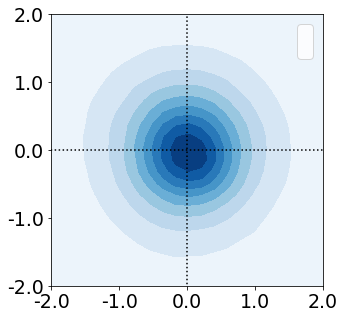

In [4]:
rho = 1.0
nx = 200
ny = 200
nz = 200
n2l = 50

simulator(rho, nx, ny, nz, n2l)

vis2d('brnd_global.bin',[nx,ny,nz,3])

- scaling check

In [5]:
#NBVAL_CHECK_OUTPUT

data = read_box('brnd_global.bin',[nx,ny,nz,3])

def b_of_z(_iz):
    assert isinstance(_iz, int)
    _nx = np.shape(data)[0]
    _ny = np.shape(data)[1]
    _nz = np.shape(data)[2]
    assert (_iz <= _nz)
    slice_z = []
    mG = 1.e-6  # CGS_unit, micro Gauss
    for i in range(_nx):
        for j in range(_ny):
            bx = data[i,j,_iz,0]/mG
            by = data[i,j,_iz,1]/mG
            bz = data[i,j,_iz,2]/mG
            slice_z.append(np.sqrt(bx**2+by**2+bz**2))
    return np.mean(slice_z),np.std(slice_z)

pick = range(0,nz,1)
b = np.zeros((len(pick),2))
for i in range(len(pick)):
    b[i] = b_of_z(pick[i])

- check the z direction scaling conceptually

(the scaling profile is described in arXiv:1907.00207)

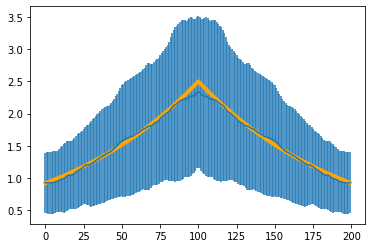

In [6]:
fig,ax = plt.subplots()
ax.errorbar(pick,b[:,0],yerr=b[:,1])

y = np.zeros(len(pick))
for i in range(len(y)):
    # the z direction scaling profile
    y[i] = 2.5*np.sqrt(np.exp(-np.fabs(pick[i]-nz/2)/(nz/4)))
ax.plot(pick,y,'orange',linewidth=4)

end